In [1]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python
!pip install pymystem3
!pip install natasha
!pip install russian-tagsets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3d902dd2a83415df88ad38cb23006fc75fc48508f73613c31881e398e1c3b941
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.2 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=9df0c692673c2d0e855734d92729bfa4f7caee498131a3df2d74522bd28e3e17
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64

**Подготовка данных:**

In [2]:
import pymorphy2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymystem3
from natasha import NewsEmbedding, NewsMorphTagger, Doc, Segmenter, MorphVocab
import re

Подготовка словаря:

In [3]:
dictionary = []

file = open("/kaggle/input/dictionary/dict.opcorpora.txt", "r")

for line in file:
    cur_line = line.strip().split()
    if len(cur_line) == 1:
        lemma_id = cur_line[0]
        lemma_flg = 1
    elif len(cur_line) == 0:
        pass
    else:
        if lemma_flg == 1:
            lemma = cur_line[0].lower()
            lemma = lemma.replace('ё', 'е')
            lemma_flg = 0
        form = cur_line[0].lower()
        form = form.replace('ё', 'е')
        pos = cur_line[1].split(',')[0]
        dictionary.append({'lemma_id': lemma_id, 'lemma': lemma, 'form': form, 'pos': pos})
        
dictionary = pd.DataFrame(dictionary)

In [4]:
dictionary

,lemma_id,lemma,form,pos
0,1,еж,еж,NOUN
1,1,еж,ежа,NOUN
2,1,еж,ежу,NOUN
3,1,еж,ежа,NOUN
4,1,еж,ежом,NOUN
...,...,...,...,...
5141288,395250,направляющая,направляющих,NOUN
5141289,395250,направляющая,направляющим,NOUN
5141290,395250,направляющая,направляющие,NOUN
5141291,395250,направляющая,направляющими,NOUN


Подготовка текстов:

In [5]:
file = open("/kaggle/input/literature-texts/Bulgakov_Master-i-Margarita.KtONuQ.524112.txt", "r")
text = file.read()
file.close()

file = open("/kaggle/input/literature-texts/Dante_Bozhestvennaya-komediya.gCwUDQ.73239.txt", "r")
text += file.read()
file.close()

file = open("/kaggle/input/literature-texts/Hoking_Teoriya-vsego-Ot-singulyarnosti-do-beskonechnosti-proishozhdenie-i-sudba-Vselennoy.ny5TIA.txt", "r")
text += file.read()
file.close()

text = text.lower()
text = text.replace('ё', 'е')

mystem = pymystem3.Mystem()
text = mystem.analyze(text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [6]:
filter_words_f = lambda x: 'analysis' in x.keys() and len(x['analysis']) != 0
filter_words_vf = np.vectorize(filter_words_f)

only_words = np.array(list(filter(filter_words_vf, text)))
only_words[:10]

array([{'analysis': [{'lex': 'издательство', 'wt': 1, 'gr': 'S,сред,неод=(вин,ед|им,ед)'}], 'text': 'издательство'},
       {'analysis': [{'lex': 'посев', 'wt': 1, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}], 'text': 'посев'},
       {'analysis': [{'lex': 'цензурный', 'wt': 1, 'gr': 'A=(вин,мн,полн,неод|им,мн,полн)'}], 'text': 'цензурные'},
       {'analysis': [{'lex': 'купюра', 'wt': 1, 'gr': 'S,жен,неод=(вин,мн|род,ед|им,мн)'}], 'text': 'купюры'},
       {'analysis': [{'lex': 'из', 'wt': 0.9999999775, 'gr': 'PR='}], 'text': 'из'},
       {'analysis': [{'lex': 'журнал', 'wt': 1, 'gr': 'S,муж,неод=род,ед'}], 'text': 'журнала'},
       {'analysis': [{'lex': 'москва', 'wt': 1, 'gr': 'S,гео,жен,неод=им,ед'}], 'text': 'москва'},
       {'analysis': [{'lex': 'и', 'wt': 0.9999770357, 'gr': 'CONJ='}], 'text': 'и'},
       {'analysis': [{'lex': 'выделять', 'wt': 1, 'gr': 'V,пе=прош,мн,прич,кр,сов,страд'}], 'text': 'выделены'},
       {'analysis': [{'lex': 'курсив', 'wt': 1, 'gr': 'S,муж,неод=твор,ед'}

In [7]:
text_f = lambda x: (x['analysis'][0]['lex'], x['text'], re.split('\W+', x['analysis'][0]['gr'])[0], 0 if 'qual' in x['analysis'][0] and x['analysis'][0]['qual'] == 'bastard' else 1)
text_vf = np.vectorize(text_f)

text_df = pd.DataFrame(np.array(text_vf(only_words)).T, columns=['lemma', 'form', 'pos', 'is_in_mystem_dictionary'])

In [8]:
text_df

,lemma,form,pos,is_in_mystem_dictionary
0,издательство,издательство,S,1
1,посев,посев,S,1
2,цензурный,цензурные,A,1
3,купюра,купюры,S,1
4,из,из,PR,1
...,...,...,...,...
261415,фейерверк,фейерверка,S,1
261416,и,и,CONJ,1
261417,художественный,художественное,A,1
261418,оформление,оформление,S,1


In [9]:
text_df.nunique()

lemma                      18882
form                       48005
pos                           14
is_in_mystem_dictionary        2
dtype: int64

Соотношение тегов:

In [10]:
dictionary['pos'].unique()

array(['NOUN', 'ADVB', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'PRTF',
       'PRTS', 'GRND', 'CONJ', 'INTJ', 'PRCL', 'PREP', 'PRED', 'NUMR',
       'NPRO'], dtype=object)

In [11]:
opencorpora_decoding = {
    'NOUN': 'существительное',
    'ADVB': 'наречие',
    'ADJF': 'прилагательное',
    'ADJS': 'прилагательное',
    'COMP': 'наречие',
    'VERB': 'глагол',
    'INFN': 'глагол',
    'PRTF': 'прилагательное',
    'PRTS': 'прилагательное',
    'GRND': 'прилагательное',
    'CONJ': 'союз',
    'INTJ': 'междометие',
    'PRCL': 'частица',
    'PREP': 'предлог',
    'PRED': 'наречие',
    'NUMR': 'числительное',
    'NPRO': 'местоимение'
}

In [12]:
opencorpora_parse_f = lambda x: opencorpora_decoding[x]
opencorpora_parse_vf = np.vectorize(opencorpora_parse_f)

In [13]:
dictionary['pos'] = opencorpora_parse_vf(dictionary['pos'])
dictionary

,lemma_id,lemma,form,pos
0,1,еж,еж,существительное
1,1,еж,ежа,существительное
2,1,еж,ежу,существительное
3,1,еж,ежа,существительное
4,1,еж,ежом,существительное
...,...,...,...,...
5141288,395250,направляющая,направляющих,существительное
5141289,395250,направляющая,направляющим,существительное
5141290,395250,направляющая,направляющие,существительное
5141291,395250,направляющая,направляющими,существительное


In [14]:
dictionary['pos'].unique()

array(['существительное', 'наречие', 'прилагательное', 'глагол', 'союз',
       'междометие', 'частица', 'предлог', 'числительное', 'местоимение'],
      dtype=object)

In [15]:
text_df['pos'].unique()

array(['S', 'A', 'PR', 'CONJ', 'V', 'APRO', 'ADV', 'SPRO', 'PART',
       'ADVPRO', 'ANUM', 'NUM', 'INTJ', 'COM'], dtype=object)

In [16]:
mystem_decoding = {
    'S': 'существительное',
    'ADV': 'наречие',
    'A': 'прилагательное',
    'COM': 'наречие',
    'V': 'глагол',
    'CONJ': 'союз',
    'INTJ': 'междометие',
    'PART': 'частица',
    'PR': 'предлог',
    'ADVPRO': 'местоимение',
    'ANUM': 'числительное',
    'NUM': 'числительное',
    'APRO': 'местоимение',
    'SPRO': 'местоимение'
}

In [17]:
mystem_parse_f = lambda x: mystem_decoding[x]
mystem_parse_vf = np.vectorize(mystem_parse_f)

In [18]:
text_df['pos'] = mystem_parse_vf(text_df['pos'])
text_df

,lemma,form,pos,is_in_mystem_dictionary
0,издательство,издательство,существительное,1
1,посев,посев,существительное,1
2,цензурный,цензурные,прилагательное,1
3,купюра,купюры,существительное,1
4,из,из,предлог,1
...,...,...,...,...
261415,фейерверк,фейерверка,существительное,1
261416,и,и,союз,1
261417,художественный,художественное,прилагательное,1
261418,оформление,оформление,существительное,1


In [19]:
text_df['pos'].unique()

array(['существительное', 'прилагательное', 'предлог', 'союз', 'глагол',
       'местоимение', 'наречие', 'частица', 'числительное', 'междометие'],
      dtype=object)

**"Разреженность данных" в коллекциях/корпусах текстов**

Статистики, посчитанные по полному совпадению словоформ, лемм и частей речи, определенных морфоанализатором и словарём:

In [20]:
dictionary_set = set(map(tuple, dictionary[['lemma', 'form', 'pos']].values)) 
text_set = set(map(tuple, text_df[['lemma', 'form', 'pos']].values)) 

missing_words = pd.DataFrame(list(dictionary_set.difference(text_set)), columns=['lemma', 'form', 'pos'])

In [21]:
print('Всего в текстах отсутствует словоформ:', missing_words.shape[0])
print('Всего в текстах отсутствует лемм:', len(missing_words['lemma'].unique()))
print('В текстах отсутствует словоформ в процентах:', missing_words.shape[0]/dictionary.shape[0]*100)
print('В текстах отсутствует лемм в процентах:', len(missing_words['lemma'].unique())/len(dictionary['lemma'].unique())*100)

Всего в текстах отсутствует словоформ: 3113689
Всего в текстах отсутствует лемм: 378235
В текстах отсутствует словоформ в процентах: 60.56237215035206
В текстах отсутствует лемм в процентах: 99.38723010665665


Частотность частей речи отсутствующих слов в порядке убывания (абсолютное значение):

In [22]:
missing_words['pos'].value_counts()

pos
прилагательное     1585190
существительное    1038779
глагол              426374
наречие              62601
междометие             266
союз                   143
числительное           138
частица                 72
местоимение             67
предлог                 59
Name: count, dtype: int64

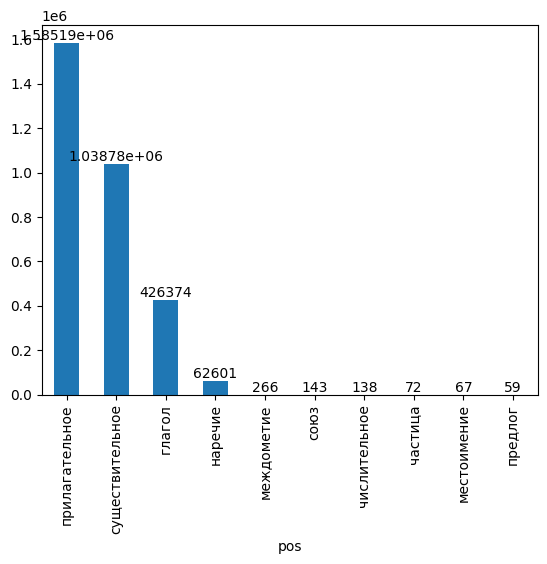

In [23]:
ax = missing_words['pos'].value_counts().plot.bar()
for container in ax.containers:
    ax.bar_label(container)

In [24]:
pos_counts = pd.concat([missing_words['pos'].value_counts(), dictionary['pos'].value_counts()], axis = 1, ignore_index=True)

Частотность частей речи отсутствующих слов в порядке убывания (относительное значение):

In [25]:
(pos_counts[0]/pos_counts[1]*100).sort_values(ascending=False)

pos
наречие            97.474425
глагол             94.400496
междометие         86.363636
союз               73.333333
существительное    72.496996
частица            52.554745
прилагательное     49.675705
предлог            42.142857
числительное       33.333333
местоимение        24.275362
dtype: float64

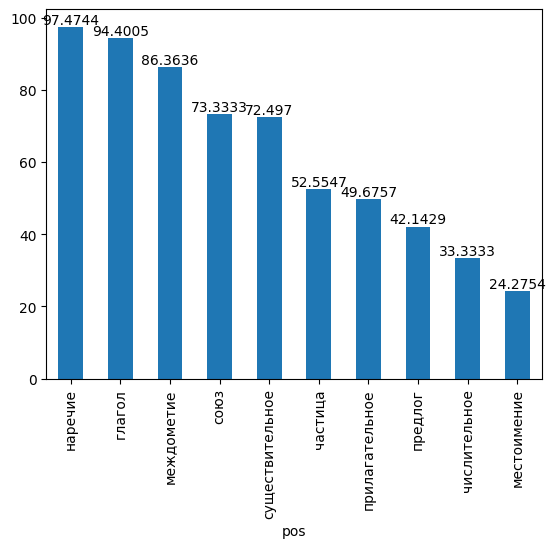

In [26]:
ax = (pos_counts[0]/pos_counts[1]*100).sort_values(ascending=False).plot.bar()
for container in ax.containers:
    ax.bar_label(container)

Примеры отсутствующих лемм и словоформ разных частей речи:

In [27]:
missing_words.drop_duplicates(subset=['pos'])

,lemma,form,pos
0,возвратно-поступательный,возвратно-поступательным,прилагательное
1,иеговович,иегововиче,существительное
19,строчусь,строчитесь,глагол
48,пухлявее,попухлявее,наречие
2326,семнадцать,семнадцать,числительное
8775,вероятно,вероятно,союз
13500,снизу,снизу,предлог
26594,бах,бах,междометие
49780,всякое,всяком,местоимение
89466,хрен,хрен,частица


Статистики, посчитанные только по полному совпадению словоформ и лемм, определенных морфоанализатором и словарём:

In [28]:
dictionary_set = set(map(tuple, dictionary[['lemma', 'form']].values)) 
text_set = set(map(tuple, text_df[['lemma', 'form']].values)) 

missing_words = pd.DataFrame(list(dictionary_set.difference(text_set)), columns=['lemma', 'form'])

In [29]:
print('Всего в текстах отсутствует словоформ:', missing_words.shape[0])
print('Всего в текстах отсутствует лемм:', len(missing_words['lemma'].unique()))
print('В текстах отсутствует словоформ в процентах:', missing_words.shape[0]/dictionary.shape[0]*100)
print('В текстах отсутствует лемм в процентах:', len(missing_words['lemma'].unique())/len(dictionary['lemma'].unique())*100)

Всего в текстах отсутствует словоформ: 3108502
Всего в текстах отсутствует лемм: 378014
В текстах отсутствует словоформ в процентах: 60.46148313274501
В текстах отсутствует лемм в процентах: 99.32915886033207


Статистики, посчитанные только по полному совпадению словоформ, определенных морфоанализатором и словарём:

In [30]:
dictionary_set = set(map(tuple, dictionary[['form']].values)) 
text_set = set(map(tuple, text_df[['form']].values)) 

missing_words = pd.DataFrame(list(dictionary_set.difference(text_set)), columns=['form'])

In [31]:
print('Всего в текстах отсутствует словоформ:', missing_words.shape[0])
print('В текстах отсутствует словоформ в процентах:', missing_words.shape[0]/dictionary.shape[0]*100)

Всего в текстах отсутствует словоформ: 3015212
В текстах отсутствует словоформ в процентах: 58.64695904318232


**Количество и процент встретившихся в выбранном тексте несловарных слов:**

Статистики, посчитанные по полному совпадению словоформ, лемм и частей речи, определенных морфоанализатором и словарём:

In [32]:
dictionary_set = set(map(tuple, dictionary[['lemma', 'form', 'pos']].values)) 
text_set = set(map(tuple, text_df[['lemma', 'form', 'pos']].values)) 

missing_words = pd.DataFrame(list(text_set.difference(dictionary_set)), columns=['lemma', 'form', 'pos'])

In [33]:
print('Всего в словаре отсутствует словоформ:', missing_words.shape[0])
print('Всего в словаре отсутствует лемм:', len(missing_words['lemma'].unique()))
print('В словаре отсутствует словоформ в процентах:', missing_words.shape[0]/text_df.shape[0]*100)
print('В словаре отсутствует лемм в процентах:', len(missing_words['lemma'].unique())/len(text_df['lemma'].unique())*100)

Всего в словаре отсутствует словоформ: 21317
Всего в словаре отсутствует лемм: 8062
В словаре отсутствует словоформ в процентах: 8.154311070308315
В словаре отсутствует лемм в процентах: 42.696748225823534


Частотность частей речи отсутствующих слов в порядке убывания (абсолютное значение):

In [34]:
missing_words['pos'].value_counts()

pos
глагол             16566
существительное     2125
прилагательное      1735
местоимение          424
наречие              312
числительное         127
предлог               11
междометие             9
частица                6
союз                   2
Name: count, dtype: int64

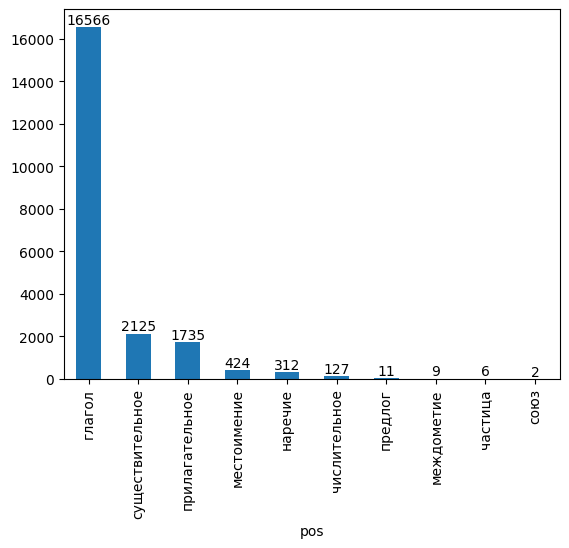

In [35]:
ax = missing_words['pos'].value_counts().plot.bar()
for container in ax.containers:
    ax.bar_label(container)

In [36]:
pos_counts = pd.concat([missing_words['pos'].value_counts(), text_df['pos'].value_counts()], axis = 1, ignore_index=True)

Частотность частей речи отсутствующих слов в порядке убывания (относительное значение):

In [37]:
(pos_counts[0]/pos_counts[1]*100).sort_values(ascending=False)

pos
глагол             35.172721
прилагательное      8.396245
числительное        4.016445
междометие          2.980132
существительное     2.760170
наречие             2.467183
местоимение         1.078030
частица             0.060030
предлог             0.040162
союз                0.008388
dtype: float64

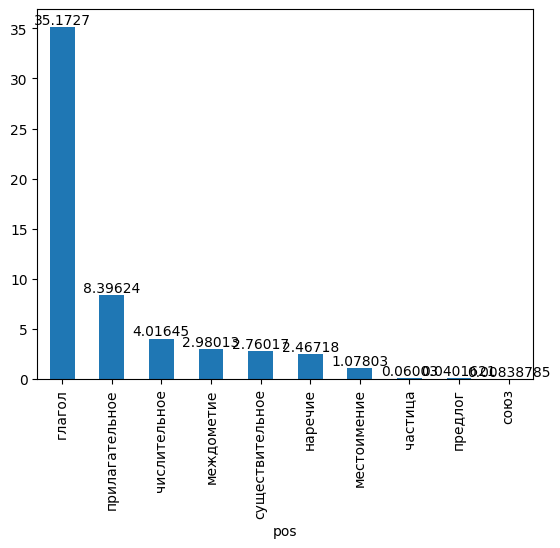

In [38]:
ax = (pos_counts[0]/pos_counts[1]*100).sort_values(ascending=False).plot.bar()
for container in ax.containers:
    ax.bar_label(container)

Список незнакомых слов с их частотами:

In [39]:
missing_words['form'].value_counts()

form
кампальдино    3
все            3
всего          3
меньше         3
тем            2
              ..
образуются     1
позднее        1
стало          1
каменею        1
прозвали       1
Name: count, Length: 21147, dtype: int64

Статистики, посчитанные только по полному совпадению словоформ и лемм, определенных морфоанализатором и словарём:

In [40]:
dictionary_set = set(map(tuple, dictionary[['lemma', 'form']].values)) 
text_set = set(map(tuple, text_df[['lemma', 'form']].values)) 

missing_words = pd.DataFrame(list(text_set.difference(dictionary_set)), columns=['lemma', 'form'])

In [41]:
print('Всего в словаре отсутствует словоформ:', missing_words.shape[0])
print('Всего в словаре отсутствует лемм:', len(missing_words['lemma'].unique()))
print('В словаре отсутствует словоформ в процентах:', missing_words.shape[0]/text_df.shape[0]*100)
print('В словаре отсутствует лемм в процентах:', len(missing_words['lemma'].unique())/len(text_df['lemma'].unique())*100)

Всего в словаре отсутствует словоформ: 20642
Всего в словаре отсутствует лемм: 7856
В словаре отсутствует словоформ в процентах: 7.8961058832530036
В словаре отсутствует лемм в процентах: 41.6057621014723


Список незнакомых слов с их частотами:

In [42]:
missing_words['form'].value_counts()

form
гульельм       2
сисмонди       2
зрим           2
похуже         2
ниже           2
              ..
забыта         1
пойдем         1
доставила      1
гноящиеся      1
притворяйся    1
Name: count, Length: 20539, dtype: int64

Статистики, посчитанные только по полному совпадению словоформ, определенных морфоанализатором и словарём:

In [43]:
dictionary_set = set(map(tuple, dictionary[['form']].values)) 
text_set = set(map(tuple, text_df[['form']].values)) 

missing_words = pd.DataFrame(list(text_set.difference(dictionary_set)), columns=['form'])

In [44]:
print('Всего в словаре отсутствует словоформ:', missing_words.shape[0])
print('В словаре отсутствует словоформ в процентах:', missing_words.shape[0]/text_df.shape[0]*100)

Всего в словаре отсутствует словоформ: 2613
В словаре отсутствует словоформ в процентах: 0.999540968556346


Список незнакомых слов с их частотами:

In [45]:
missing_words['form'].value_counts()

form
порсену        1
фарсале        1
лукинишна      1
моронто        1
амата          1
              ..
всецела        1
наказьюаете    1
вакховых       1
неуличим       1
капрайя        1
Name: count, Length: 2613, dtype: int64

**Ограниченность словаря морфопроцессора**

In [46]:
print('Процент словоформ, незнакомых словарю морфопроцессора:', 100*(1 - pd.to_numeric(text_df['is_in_mystem_dictionary']).mean()))
print('Процент уникальных словоформ, незнакомых словарю морфопроцессора:', 100*(1 - pd.to_numeric(text_df[['form', 'is_in_mystem_dictionary']].drop_duplicates()['is_in_mystem_dictionary']).mean())) 
print('Процент уникальных лемм, незнакомых словарю морфопроцессора:', 100*(1 - pd.to_numeric(text_df[['lemma', 'is_in_mystem_dictionary']].drop_duplicates()['is_in_mystem_dictionary']).mean()))

Процент словоформ, незнакомых словарю морфопроцессора: 1.5155688164639303
Процент уникальных словоформ, незнакомых словарю морфопроцессора: 4.730757212790337
Процент уникальных лемм, незнакомых словарю морфопроцессора: 10.242174280879867
